In [336]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [337]:
# use these lines at the end of data-preparation to get clipped_data.csv
"""
data = data[data.session_id <= 20000]
data.drop(['hist_user_behavior_reason_end', 'skip_1', 'skip_2', 'skip_3', 'session_id'], axis=1, inplace=True)
data.to_csv('./data/clipped_data.csv')
"""

"\ndata = data[data.session_id <= 20000]\ndata.drop(['hist_user_behavior_reason_end', 'skip_1', 'skip_2', 'skip_3', 'session_id'], axis=1, inplace=True)\ndata.to_csv('./data/clipped_data.csv')\n"

In [338]:
raw_data = pd.read_csv('./data/clipped_data.csv')
y = raw_data['not_skipped']
raw_data.drop(['not_skipped', 'Unnamed: 0'], axis=1, inplace=True)
columns = raw_data.columns
raw_data = pd.DataFrame(StandardScaler().fit_transform(raw_data), columns=columns)
X_train, X_test, y_train, y_test = train_test_split(raw_data, y, test_size = 0.25, shuffle = True, random_state= 2001)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle = True, random_state= 2022)
X_train

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
12575,-1.429275,0.681944,-0.218647,-1.578338,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,0.968958,...,0.149062,-0.975873,-0.431383,0.514973,0.951803,0.003519,-0.617304,0.470500,-0.135089,0.057216
139988,0.413331,0.681944,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,1.469694,...,0.149062,1.802820,-0.316789,0.972022,1.589783,0.923791,0.973468,0.487320,2.403868,0.134691
56216,1.518894,0.681944,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,0.134397,...,0.149062,0.617122,0.873800,0.370938,-0.174786,-1.263426,0.901582,0.819490,-0.750319,-1.698549
120888,-1.429275,0.089332,-0.218647,-1.578338,-0.404558,-0.445681,2.618657,-0.115693,-0.653611,0.134397,...,0.149062,-0.771903,0.849128,-0.967778,-1.263611,-0.887162,1.163613,0.887784,-0.625656,-0.538548
97730,0.044810,-0.206974,-0.218647,-1.578338,2.471831,2.243759,-0.134574,-0.115693,-0.653611,-0.700163,...,0.149062,-1.079259,-0.735213,0.046869,-0.269483,0.485190,-0.528858,-0.629586,-0.607584,0.485332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30451,1.887415,0.681944,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,0.968958,...,-2.874445,-0.956179,2.451101,-2.680631,-2.459658,-0.977732,0.308548,0.531793,0.257052,0.012089
152556,0.044810,-1.095892,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,-0.032515,...,0.149062,-0.470161,-0.909802,0.541354,0.691299,0.273945,-0.600785,0.054287,-0.531294,0.359749
5452,0.044810,-0.206974,-0.218647,-1.578338,2.471831,2.243759,-0.134574,-0.115693,1.529961,1.469694,...,0.149062,-1.838737,2.104809,-2.341289,-2.487015,0.333201,-0.475326,-1.218144,1.432851,1.064619
68106,0.044810,0.681944,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,-0.700163,...,0.149062,0.988427,1.247781,-1.600237,0.380791,0.892728,0.488825,-1.458435,1.523461,-2.365966


In [339]:
class SkipDataset(Dataset):

    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_idx_tmp = np.array(self.X.iloc[idx])
        y_idx_tmp = np.array(self.y.iloc[idx])

        return torch.Tensor(x_idx_tmp), torch.Tensor(y_idx_tmp) 
        



In [340]:
batch_size = 128

train_data = SkipDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle = True)

test_data = SkipDataset(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle = True)

val_data = SkipDataset(X_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle = True)

In [341]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(FeedForward, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,output_size)
        )

    def forward(self,x):
        return self.model(x)

        

In [342]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [343]:
net = FeedForward(42, 1, 32)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.05)
epochs = 20

In [345]:
print_statement = "Epoch: {} \t Loss: {:.4f} \t Avg. Validation Batch Accuracy: {:.4f} "

costs_higher_lr = []

for epoch in range(epochs):
    epoch_loss = 0

    for i, (x_inst, y_inst) in enumerate(train_dataloader):
        
        optimizer.zero_grad()

        y_pred = net.forward(x_inst)
        cost = criterion(y_pred, y_inst.reshape(-1, 1))

        cost.backward()
        optimizer.step()

        epoch_loss += cost.abs().item()

    costs_higher_lr.append(epoch_loss)

    if epoch % 2 == 0:
        n_batches = 0
        running_acc = 0
        for i, (x_val_inst, y_val_inst) in enumerate(val_dataloader):
            n_batches += 1
            y_val_pred = net.forward(x_val_inst).sigmoid().round()
            running_acc += accuracy_score(y_val_inst.detach().numpy(), y_val_pred.detach().numpy())

            
        print(print_statement.format(epoch, epoch_loss, running_acc / n_batches))

        torch.save(net.state_dict(), f"./saved_models/feed_forward_higher_lr_{epoch}.pt")


Epoch: 0 	 Loss: 391.2902 	 Avg. Validation Batch Accuracy: 0.7926 
Epoch: 2 	 Loss: 325.8636 	 Avg. Validation Batch Accuracy: 0.7963 
Epoch: 4 	 Loss: 318.3025 	 Avg. Validation Batch Accuracy: 0.7999 
Epoch: 6 	 Loss: 316.8844 	 Avg. Validation Batch Accuracy: 0.7981 
Epoch: 8 	 Loss: 315.9724 	 Avg. Validation Batch Accuracy: 0.8008 
Epoch: 10 	 Loss: 315.2097 	 Avg. Validation Batch Accuracy: 0.7999 
Epoch: 12 	 Loss: 314.5549 	 Avg. Validation Batch Accuracy: 0.8008 
Epoch: 14 	 Loss: 314.0966 	 Avg. Validation Batch Accuracy: 0.8013 
Epoch: 16 	 Loss: 313.4842 	 Avg. Validation Batch Accuracy: 0.8005 
Epoch: 18 	 Loss: 312.9091 	 Avg. Validation Batch Accuracy: 0.8009 
Epoch: 20 	 Loss: 312.5522 	 Avg. Validation Batch Accuracy: 0.7997



In [346]:
net.load_state_dict(torch.load(f'./saved_models/feed_forward_higher_lr_20.pt'))
correct = 0
for x_inst, y_inst in test_data:
    y_pred = net.forward(x_inst)
    correct += (1 - (y_pred.sigmoid().round() - y_inst).abs()).abs()

acc = (correct / len(test_data)).item()
print(f"Epoch: 20 \t Accuracy: {acc}")

Epoch: 20 	 Accuracy: 0.7972186803817749


In [347]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [348]:
y_test_np = y_test.to_numpy()
y_train_np = y_train.to_numpy()

test_accs = []
train_accs = []

for i in range(0, 22, 2):
    net.load_state_dict(torch.load(f'./saved_models/feed_forward_higher_lr_{i}.pt'))    
    y_hat = net.forward(torch.Tensor(X_test.to_numpy())).sigmoid().round().detach()
    y_hat = y_hat.reshape(len(y_hat), ).numpy()

    #Testing Scores
    test_acc = accuracy_score(y_test_np, y_hat)
    test_accs.append(test_acc)

    prec = precision_score(y_test_np, y_hat)
    rec = recall_score(y_test_np, y_hat)
    f = f1_score(y_test_np, y_hat)

    #Training Accuracy
    y_train_hat = net.forward(torch.Tensor(X_train.to_numpy())).sigmoid().round().detach()
    training_acc = accuracy_score(y_train_np, y_train_hat)
    train_accs.append(training_acc)

    template = "Epoch: {} Training Accuracy: {:.5f} Testing Accuracy: {:.5f} Precision: {:.5f} Recall: {:.5f} F1: {:.5f}"
    print(template.format(i, training_acc, test_acc, prec, rec, f))

Epoch: 0 Training Accuracy: 0.79182 Testing Accuracy: 0.78858 Precision: 0.73682 Recall: 0.55449 F1: 0.63278
Epoch: 2 Training Accuracy: 0.79632 Testing Accuracy: 0.79331 Precision: 0.76659 Recall: 0.53318 F1: 0.62893
Epoch: 4 Training Accuracy: 0.79910 Testing Accuracy: 0.79659 Precision: 0.77320 Recall: 0.53891 F1: 0.63514
Epoch: 6 Training Accuracy: 0.79895 Testing Accuracy: 0.79599 Precision: 0.75421 Recall: 0.56221 F1: 0.64421
Epoch: 8 Training Accuracy: 0.80030 Testing Accuracy: 0.79765 Precision: 0.77230 Recall: 0.54465 F1: 0.63880
Epoch: 10 Training Accuracy: 0.79938 Testing Accuracy: 0.79688 Precision: 0.75342 Recall: 0.56743 F1: 0.64733
Epoch: 12 Training Accuracy: 0.79948 Testing Accuracy: 0.79765 Precision: 0.76415 Recall: 0.55552 F1: 0.64335
Epoch: 14 Training Accuracy: 0.80010 Testing Accuracy: 0.79729 Precision: 0.76864 Recall: 0.54788 F1: 0.63975
Epoch: 16 Training Accuracy: 0.80077 Testing Accuracy: 0.79700 Precision: 0.76463 Recall: 0.55200 F1: 0.64114
Epoch: 18 Train

In [352]:
import matplotlib.pyplot as plt
%matplotlib inline

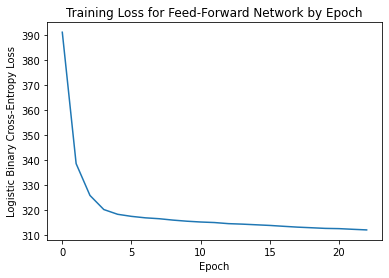

In [353]:
plt.plot(costs_higher_lr)
plt.xlabel("Epoch")
plt.ylabel("Logistic Binary Cross-Entropy Loss")
plt.title("Training Loss for Feed-Forward Network by Epoch")
plt.savefig("Loss.png")

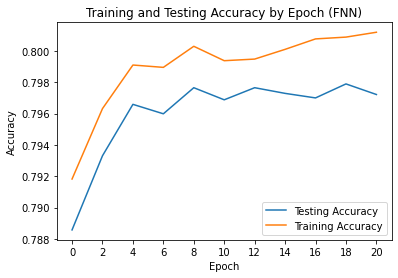

In [354]:
plt.plot(range(0, 22, 2), test_accs, label="Testing Accuracy")
plt.plot(range(0, 22, 2), train_accs, label="Training Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.xticks(range(0,22, 2))
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy by Epoch (FNN)")
plt.savefig("accuracy.png")


In [357]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

net.load_state_dict(torch.load(f'./saved_models/feed_forward_higher_lr_20.pt'))    
y_proba = net.forward(torch.Tensor(X_test.to_numpy())).sigmoid().detach()

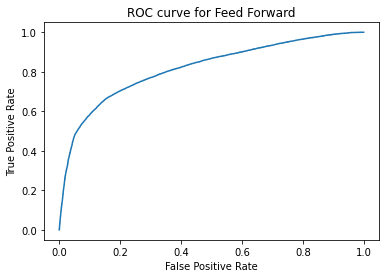

In [358]:
fpr, tpr, _ = roc_curve(y_test, y_proba)


fpr, tpr, tresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Feed Forward")
plt.savefig("FNN_roc.png")

In [359]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_proba)

0.8174930420021056